*Для анализа был выбран временной ряд "Данные о продажах в онлайн-ритейлере"*

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

%matplotlib inline

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rainfall = pd.read_csv('rainfall.csv', index_col=['date'], parse_dates=['date'])

Визуализируйте ряд и на основе его внешнего вида сделайте предположения о его компонентах (тренд, сезонность) и стационарности



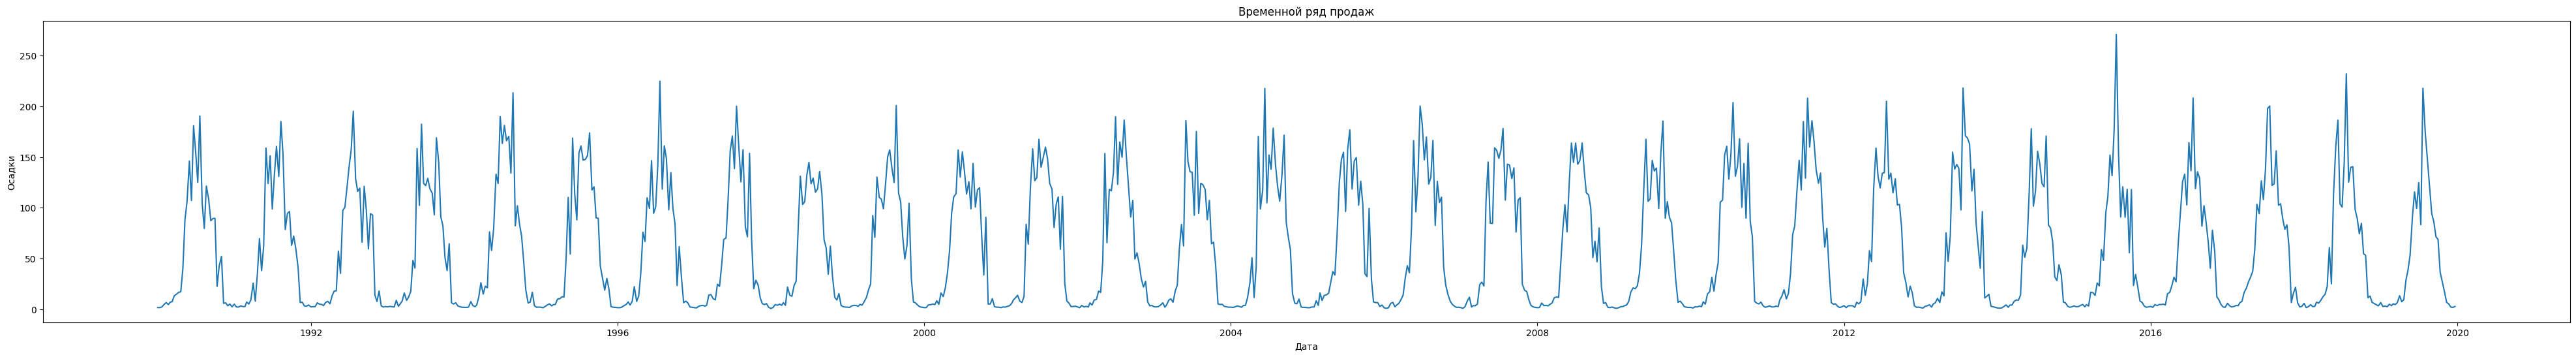

In [5]:
plt.figure(figsize=(50, 6))
sns.lineplot(x=rainfall.index, y='mean_rainfall', data=rainfall)
plt.title('Временной ряд продаж')
plt.xlabel('Дата')
plt.ylabel('Осадки')
plt.show()

*Видна годовая переодичность, общего тренда нет*

Сделайте train/test split

In [6]:
def timeseries_train_test_split(X, y, test_size):
    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

data = pd.DataFrame(rainfall.mean_rainfall.copy())
data.columns = ["y"]

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

#Бейзлайн

Постройте бейзлайн в виде наивного прогноза или скользящего среднего

In [7]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(rainfall, 30) #


50.033199999999994

In [8]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(50,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")

        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Визуализируйте результаты работы модели, произведите замеры качества бейзлайна с релевантной, на ваш взгляд, метрикой

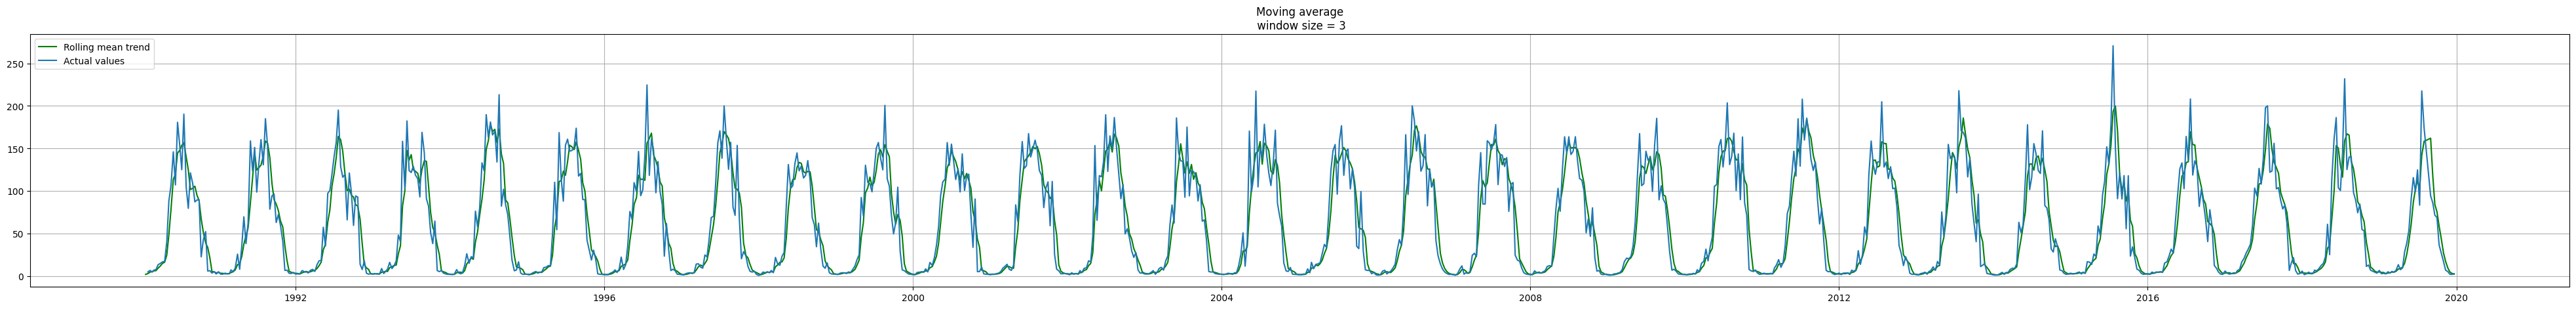

In [9]:
plotMovingAverage(rainfall, 3)

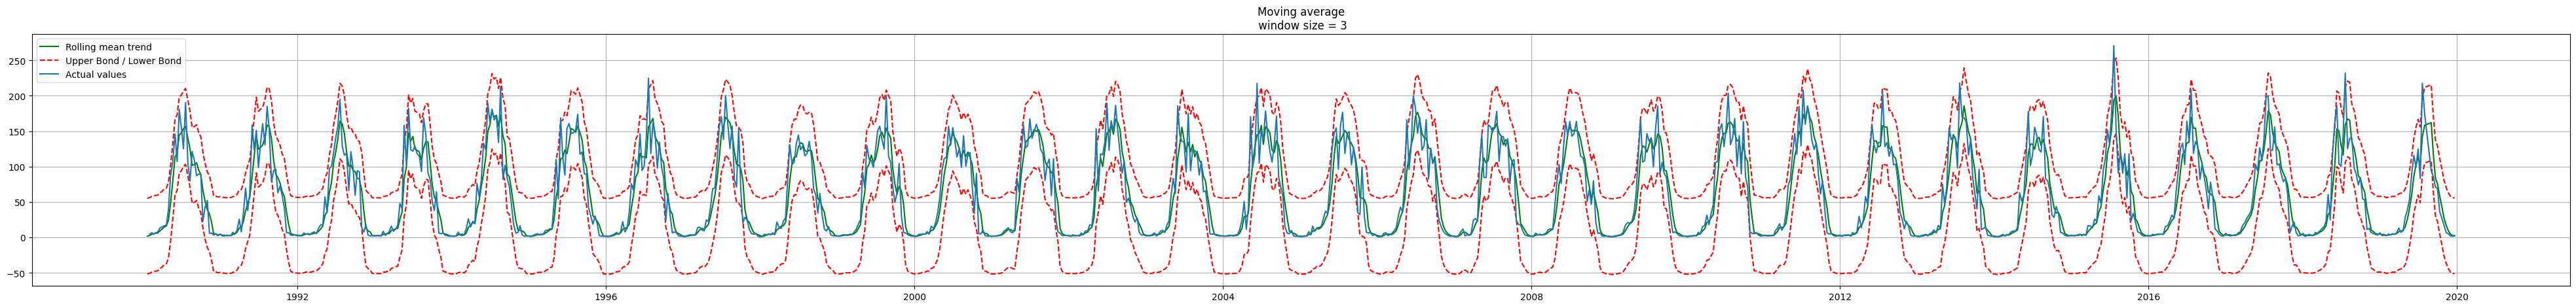

In [10]:
plotMovingAverage(rainfall, 3, plot_intervals=True)

*Тренда не видно, но есть переодичность*

In [11]:
rolling_mean = rainfall.rolling(window=4).mean()
mse = mean_squared_error(rainfall[4:], rolling_mean[4:])
mse

588.6012218296671

#Статистическая модель

Проведите тест Дики-Фуллера и интерпретируйте результаты

Постройте графики ACF/PACF и проанализируйте их, сделайте предположения о наличии/отсутствии сезонности

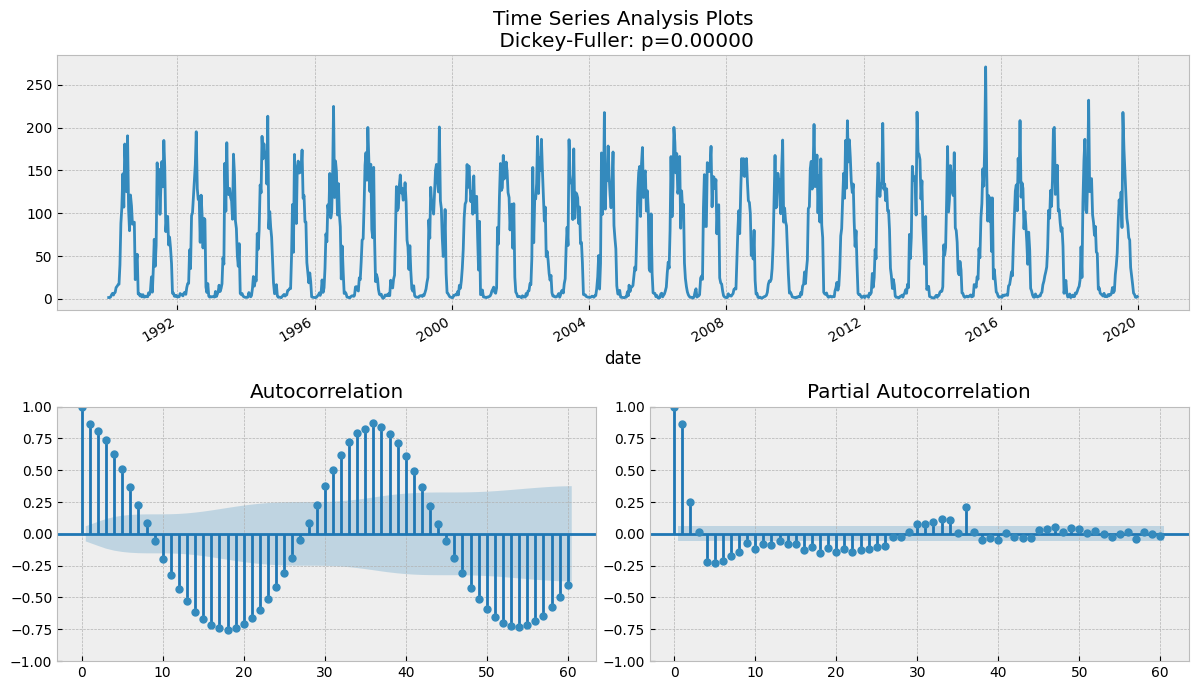

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(rainfall.mean_rainfall, lags=60)

*Так как значение p-value < 0.05, по тесту Дики-Фуллера ряд считаестя стационарным, но из-за переодичности он таковым не является*

*На автоколеляции видна периодичность*



Проведите необходимые на ваш взгляд преобразования для придания ряду стационарности (дифференцирование / сезонное дифференцирование)

In [ ]:
rainfall_diff = rainfall.mean_rainfall - rainfall.mean_rainfall.shift(36) # 3 измерения в месяц * 12 месяцев

Проверьте стационарность полученного ряда с тестом Дики-Фуллера и визуализацией ACF/PACF

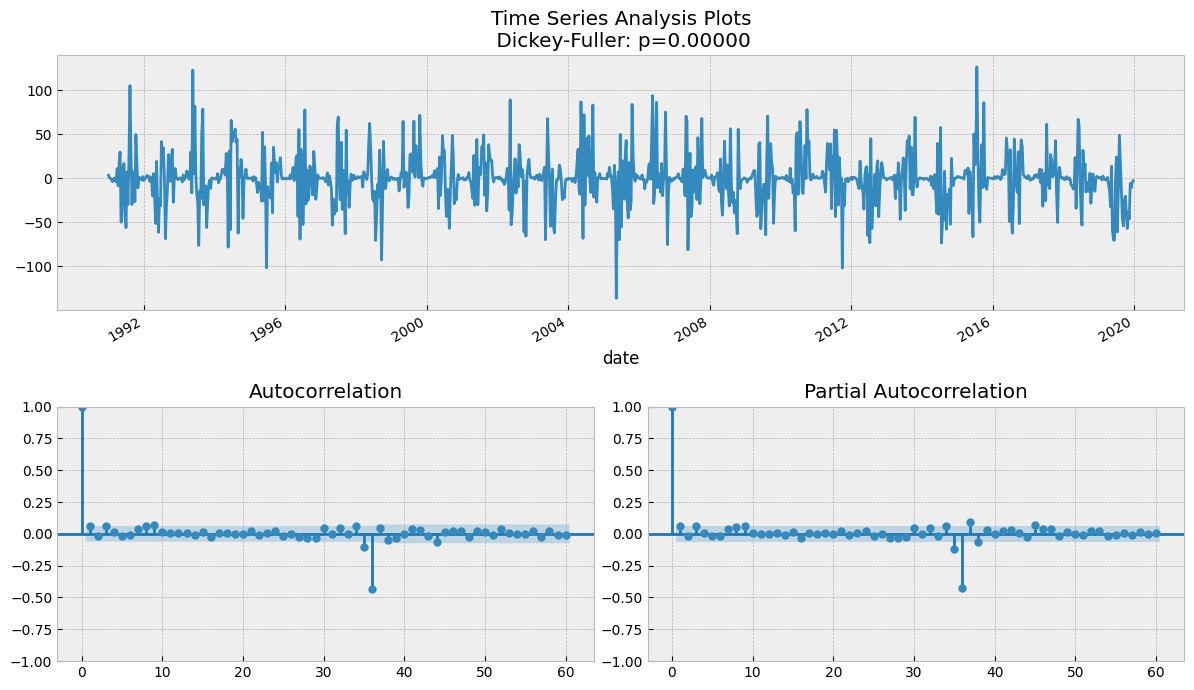

In [ ]:
tsplot(rainfall_diff[36:], lags=60)

 *Автокорреляционная функция имеет значительный 36 лаг. Чтобы его удалить, проведем дифференцирование*

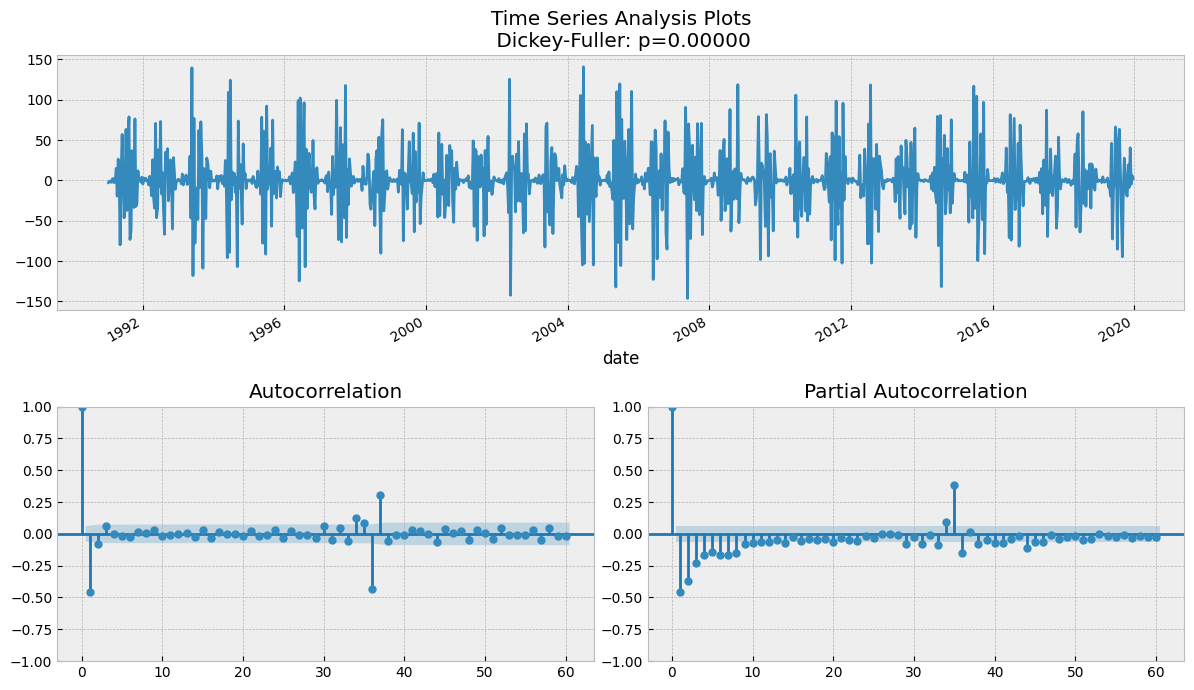

In [ ]:
rainfall_diff_2 = rainfall_diff - rainfall_diff.shift(1)
tsplot(rainfall_diff_2[36+1:], lags=60)


*Лагов стало больше*

Для сокращения времени обучения возьмём среднее значение за неделю

Обучите модель ARIMA или SARIMA для прогнозирования значений ряда, подобрав оптимальные параметры

In [ ]:
ps = range(36, 37)
d=1
qs = range(36, 37)
Ps = range(0, 1)
D=1
Qs = range(0, 2)
s = 36

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

2

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(rainfall.mean_rainfall, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

In [ ]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CPU times: user 14min 51s, sys: 5min 3s, total: 19min 55s
Wall time: 11min 18s


In [ ]:
result_table.head()

parameters          aic
0  (36, 36, 0, 0)  9411.915818

In [ ]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(rainfall.mean_rainfall, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                       
Dep. Variable:                         mean_rainfall   No. Observations:                 1078
Model:             SARIMAX(36, 1, 36)x(0, 1, [], 36)   Log Likelihood               -4632.958
Date:                               Mon, 04 Mar 2024   AIC                           9411.916
Time:                                       14:08:43   BIC                           9773.115
Sample:                                            0   HQIC                          9548.929
                                              - 1078                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8929      0.038    -23.572      0.000      -0.967      -0.819
ar.L2      

Визуализируйте результаты работы модели, произведите замеры качества модели ARIMA (или SARIMA), сравните с бейзлайном

In [ ]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


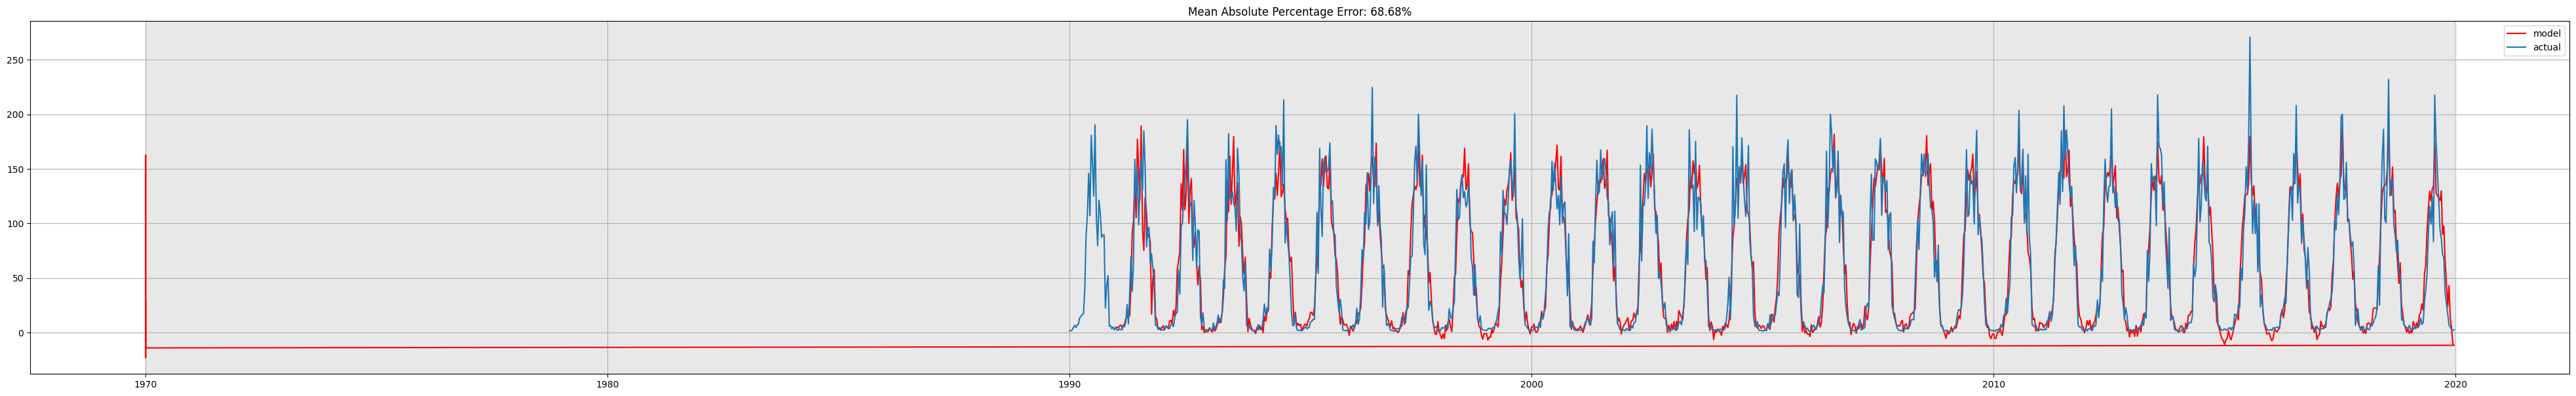

In [ ]:
def plotSARIMA(series, model, n_steps):

    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN

    # forecasting on n_steps forward
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(50, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

plotSARIMA(rainfall, best_model, 50)

#Классическая модель

Используйте Feature-Engineering для создания признаков (лаги, скользящие статистики, признаки даты/времени etc)

In [28]:
data = pd.DataFrame(rainfall.mean_rainfall.copy())
data.columns = ["y"]

for i in range(6, 38):
    data["lag_{}".format(i)] = data.y.shift(i)

data.tail(7)

y    lag_6    lag_7    lag_8    lag_9   lag_10   lag_11  \
date                                                                       
2019-10-21  27.367  174.259  217.653   83.297  124.734   99.326  115.623   
2019-11-01  16.856   94.172  174.259  217.653   83.297  124.734   99.326   
2019-11-11   6.737   86.126   94.172  174.259  217.653   83.297  124.734   
2019-11-21   5.216   71.462   86.126   94.172  174.259  217.653   83.297   
2019-12-01   2.022   68.751   71.462   86.126   94.172  174.259  217.653   
2019-12-11   1.780   36.663   68.751   71.462   86.126   94.172  174.259   
2019-12-21   2.694   27.367   36.663   68.751   71.462   86.126   94.172   

             lag_12   lag_13   lag_14  ...  lag_28  lag_29  lag_30  lag_31  \
date                                   ...                                   
2019-10-21   90.929   53.567   38.641  ...   3.332   4.382   5.613   6.700   
2019-11-01  115.623   90.929   53.567  ...   6.501   3.332   4.382   5.613   
2019-11-11   99.326  115.623   90.929  ...   2.645   6.501   3.332   4.382   
2019-11-21  124.734   99.326  115.623  ...   3.084   2.645   6.501   3.332   
2019-12-01   83.297  124.734   99.326  ...   2.460   3.084   2.645   6.501   
2019-12-11  217.653   83.297  124.734  ...   4.915   2.460   3.084   2.645   
2019-12-21  174.259  217.653   83.297  ...   3.442   4.915   2.460   3.084   

            lag_32  lag_33  lag_34  lag_35  lag_36  lag_37  
date                                                        
2019-10-21  12.882  11.245  53.160  54.645  84.529  74.326  
2019-11-01   6.700  12.882  11.245  53.160  54.645  84.529  
2019-11-11   5.613   6.700  12.882  11.245  53.160  54.645  
2019-11-21   4.382   5.613   6.700  12.882  11.245  53.160  
2019-12-01   3.332   4.382   5.613   6.700  12.882  11.245  
2019-12-11   6.501   3.332   4.382   5.613   6.700  12.882  
2019-12-21   2.645   6.501   3.332   4.382   5.613   6.700  

[7 rows x 33 columns]

In [29]:
data.index = pd.to_datetime(data.index)
data["year"] = data.index.year
data["month"] = data.index.month
data['rolling_mean'] = data['y'].rolling(window=4).mean()

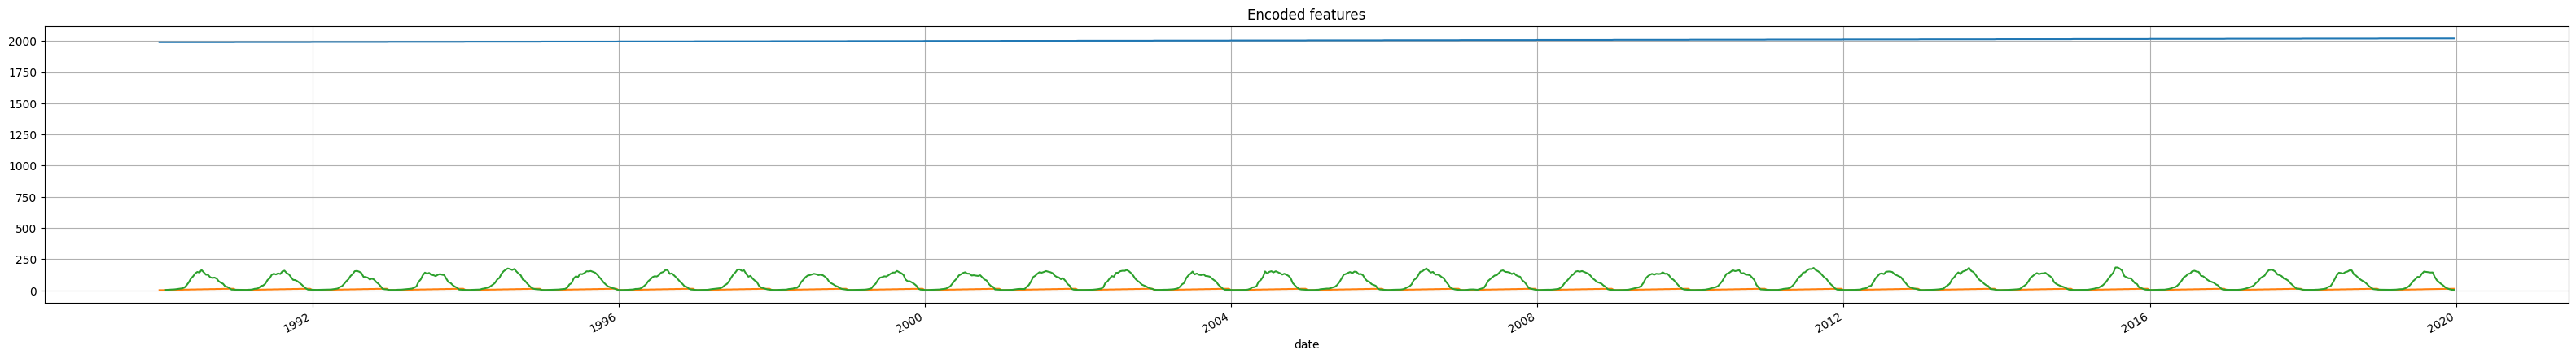

In [30]:
plt.figure(figsize=(40, 5))
plt.title("Encoded features")
data.year.plot()
data.month.plot()
data.rolling_mean.plot()
plt.grid();

In [31]:
def timeseries_train_test_split(X, y, test_size):

    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
from sklearn.ensemble import RandomForestRegressor


In [34]:
rf = RandomForestRegressor()
rf.fit(X_train_scaled, y_train)

RandomForestRegressor()

Визуализируйте результаты работы модели, произведите замеры качества модели, сравните с прошлыми экспериментами

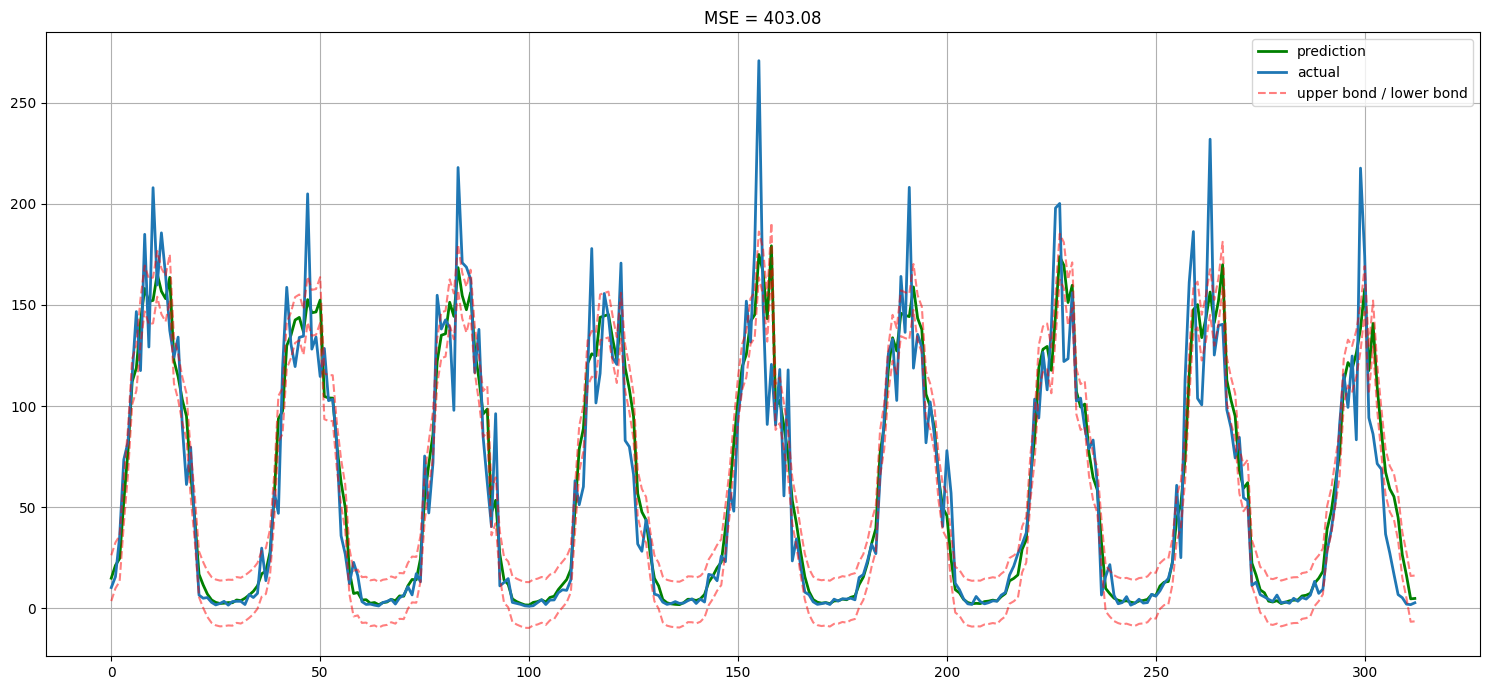

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train,
                                    cv=tscv,
                                    scoring="neg_median_absolute_error")
        mse_met = cv.mean() * (-1)
        deviation = cv.std()

        scale = 1.96
        lower = prediction - (mse_met + scale * deviation)
        upper = prediction + (mse_met + scale * deviation)

        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)

        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_testupper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")

    error = mean_squared_error(prediction, y_test)
    plt.title("MSE = {0:.2f}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

plotModelResults(rf, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)

#Интерпретация

Проинтерпретируйте модель, полученную в шаге **Классическая модель** с помощью:
- permutation importance

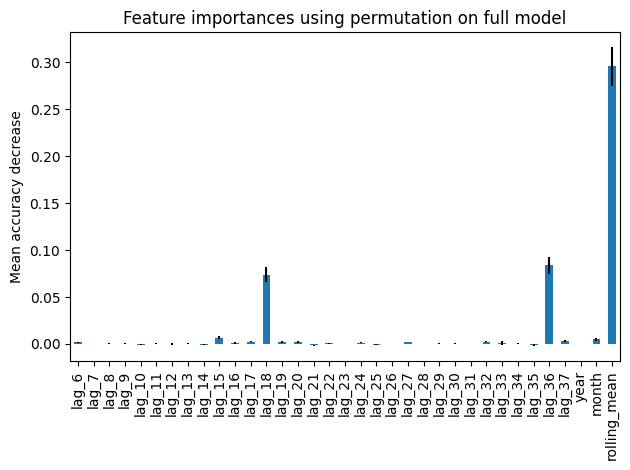

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

importances = permutation_importance(rf, X_test_scaled, y_test[:315], n_repeats=10, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Явно выделяется 18 и 36 лаг, также большое значение у rolling_mean

- LIME

In [37]:
!pip install -U numpy==1.23.1 shap lime
from lime import lime_tabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 28.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=01b32c8fb389c1dca950465cdad2c4e624939d015057f4071cdffc8f9c1548c5
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.85 requires numpy>=1.24.1, but you have numpy 1.23.1 which is incompatible.
tensorflow 2.15.0 req

In [38]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train_scaled.values,
    feature_names=X_train.columns,
    class_names=['rings'],
    verbose=True,
    mode='regression',
)
i = 33
exp = explainer.explain_instance(X_test.iloc[i].values, rf.predict, num_features=5);

exp.show_in_notebook(show_table=True)

Intercept 48.373705705548716
Prediction_local [102.06168103]
Right: 114.86108000000004


In [39]:
exp.as_list()

[('rolling_mean > 1.05', 43.55425074915196),
 ('lag_36 > 0.87', 22.30856049533629),
 ('lag_18 > 0.89', -15.157056013245425),
 ('lag_37 > 0.87', 5.83734457693008),
 ('month > 0.74', -2.8551244876799378)]

SHAP

In [40]:
import shap

explainer = shap.TreeExplainer(rf)

In [41]:
choosen_instance = X_test_scaled.loc[[100]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [42]:
choosen_instance = X_test_scaled.loc[[4]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

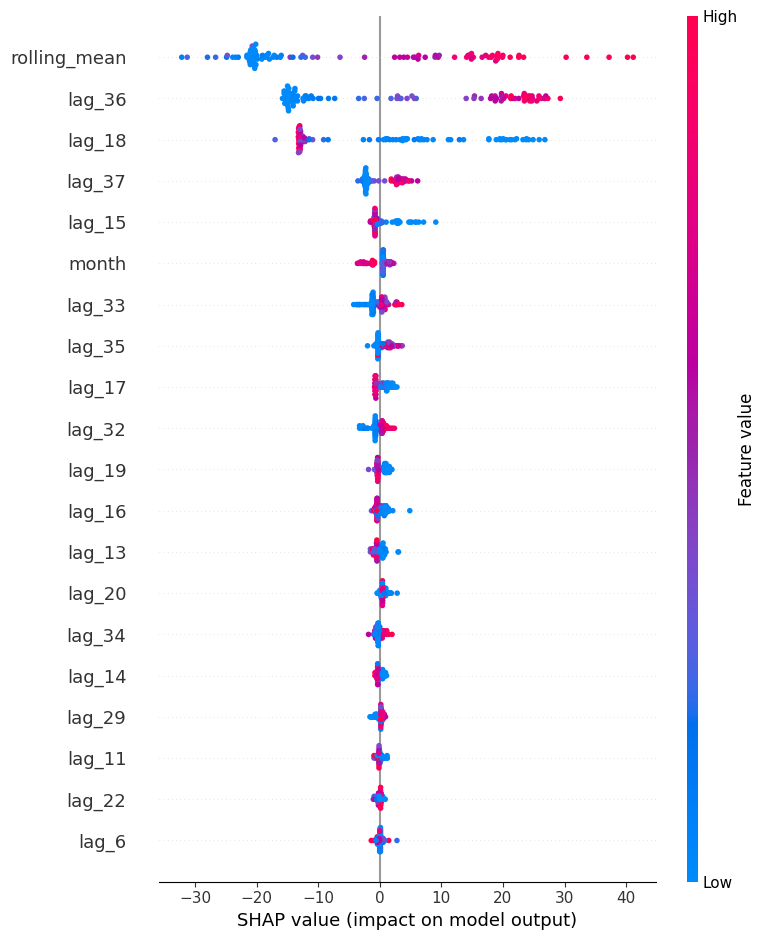

In [43]:
shap_values = explainer.shap_values(X_train_scaled.iloc[:100])
shap.summary_plot(shap_values, X_train_scaled.iloc[:100])

Снова можно сделать вывод, что модель отдала большое значение rolling_mean, 18 и 36 лагу
